# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

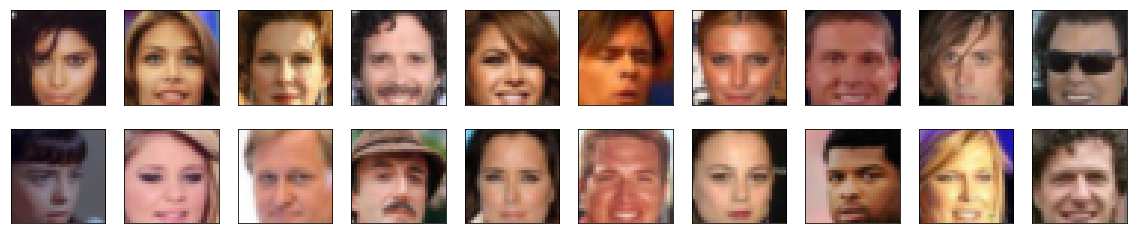

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    
    x = x *(max-min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9059)
Max:  tensor(0.7569)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
#helper conv function
def conv(in_channels, out_channels,kernel_size,stride=2,padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size,stride,padding,bias=False )
    
    layers.append(conv_layer)
    if batch_norm:
#         layers.append(nn.BatchNorm2d(out_channels))
          layers.append(nn.InstanceNorm2d(out_channels))
    
    return nn.Sequential(*layers)
        

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        #input 32x32x3
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        #input 16x16xconv_dim
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        #input 8x8xconv_dim*2
        self.conv3 = conv(conv_dim *2, conv_dim*4, 4)
        #input 4x4xconv_dim*4
        self.conv4 = conv(conv_dim *4, conv_dim*8, 4)
        #input 2x2xconv_dim*8
        self.fc = nn.Linear(2*2*conv_dim*8, 1)
        self.dropout2d = nn.Dropout2d(0.2)
        self.dropout = nn.Dropout(0.2)
        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x),0.2)
        out = F.leaky_relu(self.conv2(out),0.2)
        out = self.dropout2d(out)
        out = F.leaky_relu(self.conv3(out),0.2)
        out = self.dropout2d(out)
        out = F.leaky_relu(self.conv4(out),0.2)
        out = out.view(-1,2*2*self.conv_dim*8)
        out = self.dropout(out)
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
#helper deconv function
def deconv(in_channels, out_channels,kernel_size,stride=2,padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,stride,padding,bias=False )
    
    layers.append(deconv_layer)
    if batch_norm:
#         layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.InstanceNorm2d(out_channels))
    
    return nn.Sequential(*layers)
        

In [13]:
# residual block class
class ResidualBlock(nn.Module):
   
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
    
        self.dconv_layer1 = deconv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.dconv_layer2 = deconv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.dconv_layer1(x))
        out_2 = x + self.dconv_layer2(out_1)
        return out_2

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim *8*2*2)
        self.deconv1 = deconv(conv_dim *8,conv_dim *4, 4)
        self.deconv2 = deconv(conv_dim *4,conv_dim *2, 4)
        self.deconv3 = deconv(conv_dim *2,conv_dim , 4)
        # Residual blocks
        res_layers = []
        for layer in range(4):
            res_layers.append(ResidualBlock(conv_dim))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)
        
        self.deconv4 = deconv(conv_dim ,3, 4,batch_norm=False)
        self.dropout2d = nn.Dropout2d(0.2)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1,self.conv_dim*8, 2,2)# (batch_size, depth, 2, 2)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = self.dropout2d(out)
        out = F.relu(self.deconv3(out))
        out = self.dropout2d(out)
        out = self.res_blocks(out)
        out = self.dropout2d(out)
        out = torch.tanh(self.deconv4(out))
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m,'weight') and (classname.find('Conv')!=-1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data,0.0,0.02)
        
        if hasattr(m,'bias') and m.bias is not None:
            nn.init.constant_(m.bias,0.0)
    
    elif classname.find('BatchNorm2d')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias,0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.2)
  (dropout): Dropout(p=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTr

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim
# params
lr = 0.0001
beta1=0.1
beta2=0.999 
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            d_real_out = D(real_images)
            d_real_loss = real_loss(d_real_out,smooth=True)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_img = G(z)
            
            d_fake_out = D(fake_img)
            d_fake_loss = fake_loss(d_fake_out)
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_img = G(z)
            
            d_fake_out = D(fake_img)
            
            g_loss = real_loss(d_fake_out)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.8105 | g_loss: 1.3629
Epoch [    1/   50] | d_loss: 1.8067 | g_loss: 11.8823
Epoch [    1/   50] | d_loss: 0.7202 | g_loss: 9.1487
Epoch [    1/   50] | d_loss: 0.6395 | g_loss: 4.2467
Epoch [    1/   50] | d_loss: 0.5895 | g_loss: 5.0400
Epoch [    1/   50] | d_loss: 0.5183 | g_loss: 3.4285
Epoch [    1/   50] | d_loss: 0.4940 | g_loss: 3.8524
Epoch [    1/   50] | d_loss: 0.5451 | g_loss: 3.4736
Epoch [    1/   50] | d_loss: 0.5114 | g_loss: 3.7618
Epoch [    1/   50] | d_loss: 0.5616 | g_loss: 3.5847
Epoch [    1/   50] | d_loss: 0.7071 | g_loss: 1.9756
Epoch [    1/   50] | d_loss: 0.6072 | g_loss: 3.2243
Epoch [    1/   50] | d_loss: 0.5264 | g_loss: 3.2198
Epoch [    1/   50] | d_loss: 1.0337 | g_loss: 7.8170
Epoch [    1/   50] | d_loss: 0.5921 | g_loss: 4.0674
Epoch [    1/   50] | d_loss: 0.5894 | g_loss: 3.8220
Epoch [    1/   50] | d_loss: 0.7779 | g_loss: 3.8715
Epoch [    1/   50] | d_loss: 1.0785 | g_loss: 1.5050
Epoch [    1/   50] | d_los

Epoch [    6/   50] | d_loss: 0.8635 | g_loss: 2.1737
Epoch [    6/   50] | d_loss: 0.7826 | g_loss: 2.1627
Epoch [    6/   50] | d_loss: 0.8010 | g_loss: 3.2397
Epoch [    6/   50] | d_loss: 0.6065 | g_loss: 2.4269
Epoch [    6/   50] | d_loss: 0.9142 | g_loss: 1.9590
Epoch [    6/   50] | d_loss: 0.9554 | g_loss: 2.2370
Epoch [    6/   50] | d_loss: 0.8584 | g_loss: 2.8100
Epoch [    6/   50] | d_loss: 0.9724 | g_loss: 4.0789
Epoch [    6/   50] | d_loss: 0.8533 | g_loss: 2.7860
Epoch [    6/   50] | d_loss: 0.7178 | g_loss: 2.4125
Epoch [    6/   50] | d_loss: 0.8497 | g_loss: 1.9588
Epoch [    6/   50] | d_loss: 0.8257 | g_loss: 1.8384
Epoch [    6/   50] | d_loss: 0.6328 | g_loss: 2.7378
Epoch [    6/   50] | d_loss: 0.7500 | g_loss: 2.2779
Epoch [    6/   50] | d_loss: 1.3140 | g_loss: 1.2624
Epoch [    6/   50] | d_loss: 0.7159 | g_loss: 3.0817
Epoch [    6/   50] | d_loss: 0.6916 | g_loss: 3.1251
Epoch [    6/   50] | d_loss: 0.7891 | g_loss: 3.0951
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.6588 | g_loss: 3.9430
Epoch [   11/   50] | d_loss: 0.5760 | g_loss: 2.9492
Epoch [   11/   50] | d_loss: 0.4828 | g_loss: 4.3684
Epoch [   11/   50] | d_loss: 0.5787 | g_loss: 3.8331
Epoch [   11/   50] | d_loss: 1.3775 | g_loss: 1.5563
Epoch [   11/   50] | d_loss: 0.7780 | g_loss: 2.7519
Epoch [   11/   50] | d_loss: 0.6293 | g_loss: 2.5244
Epoch [   11/   50] | d_loss: 1.1197 | g_loss: 3.7552
Epoch [   11/   50] | d_loss: 0.8452 | g_loss: 3.2044
Epoch [   11/   50] | d_loss: 0.6490 | g_loss: 3.1161
Epoch [   11/   50] | d_loss: 0.9699 | g_loss: 3.3685
Epoch [   11/   50] | d_loss: 0.5799 | g_loss: 4.0184
Epoch [   11/   50] | d_loss: 0.7750 | g_loss: 3.1730
Epoch [   11/   50] | d_loss: 0.6893 | g_loss: 3.4975
Epoch [   11/   50] | d_loss: 0.9227 | g_loss: 2.0683
Epoch [   12/   50] | d_loss: 0.7054 | g_loss: 2.8920
Epoch [   12/   50] | d_loss: 0.7062 | g_loss: 2.8500
Epoch [   12/   50] | d_loss: 0.8537 | g_loss: 1.9252
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.7839 | g_loss: 3.3453
Epoch [   16/   50] | d_loss: 0.5717 | g_loss: 3.2234
Epoch [   16/   50] | d_loss: 0.6485 | g_loss: 2.5448
Epoch [   16/   50] | d_loss: 0.5172 | g_loss: 4.9057
Epoch [   16/   50] | d_loss: 0.5529 | g_loss: 3.2813
Epoch [   16/   50] | d_loss: 0.5721 | g_loss: 3.6826
Epoch [   16/   50] | d_loss: 0.5908 | g_loss: 3.7782
Epoch [   16/   50] | d_loss: 0.6399 | g_loss: 4.0935
Epoch [   17/   50] | d_loss: 0.6436 | g_loss: 3.2095
Epoch [   17/   50] | d_loss: 0.6309 | g_loss: 3.9294
Epoch [   17/   50] | d_loss: 1.2213 | g_loss: 2.7379
Epoch [   17/   50] | d_loss: 0.5083 | g_loss: 3.4913
Epoch [   17/   50] | d_loss: 0.7960 | g_loss: 3.4715
Epoch [   17/   50] | d_loss: 0.6858 | g_loss: 4.1935
Epoch [   17/   50] | d_loss: 0.7730 | g_loss: 3.2628
Epoch [   17/   50] | d_loss: 0.6764 | g_loss: 3.3802
Epoch [   17/   50] | d_loss: 0.4050 | g_loss: 4.5302
Epoch [   17/   50] | d_loss: 0.6622 | g_loss: 3.8384
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.7874 | g_loss: 2.2090
Epoch [   22/   50] | d_loss: 0.7572 | g_loss: 3.0376
Epoch [   22/   50] | d_loss: 0.5204 | g_loss: 4.1663
Epoch [   22/   50] | d_loss: 0.7029 | g_loss: 4.4072
Epoch [   22/   50] | d_loss: 0.8527 | g_loss: 5.0871
Epoch [   22/   50] | d_loss: 0.7186 | g_loss: 3.3073
Epoch [   22/   50] | d_loss: 0.7170 | g_loss: 5.7628
Epoch [   22/   50] | d_loss: 0.5101 | g_loss: 3.8556
Epoch [   22/   50] | d_loss: 0.7614 | g_loss: 1.8715
Epoch [   22/   50] | d_loss: 1.0612 | g_loss: 3.5751
Epoch [   22/   50] | d_loss: 0.5948 | g_loss: 3.8648
Epoch [   22/   50] | d_loss: 0.4847 | g_loss: 4.8920
Epoch [   22/   50] | d_loss: 0.9239 | g_loss: 1.8831
Epoch [   22/   50] | d_loss: 0.7171 | g_loss: 3.2877
Epoch [   22/   50] | d_loss: 0.4505 | g_loss: 4.3216
Epoch [   22/   50] | d_loss: 0.6004 | g_loss: 3.7248
Epoch [   22/   50] | d_loss: 0.5092 | g_loss: 4.2633
Epoch [   22/   50] | d_loss: 0.8002 | g_loss: 2.9199
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.4582 | g_loss: 4.4923
Epoch [   27/   50] | d_loss: 0.7224 | g_loss: 2.4609
Epoch [   27/   50] | d_loss: 0.5118 | g_loss: 4.3059
Epoch [   27/   50] | d_loss: 0.6821 | g_loss: 1.5515
Epoch [   27/   50] | d_loss: 0.4588 | g_loss: 5.2811
Epoch [   27/   50] | d_loss: 0.4422 | g_loss: 3.7020
Epoch [   27/   50] | d_loss: 0.4294 | g_loss: 5.7463
Epoch [   27/   50] | d_loss: 0.5452 | g_loss: 4.0119
Epoch [   27/   50] | d_loss: 0.5683 | g_loss: 4.4981
Epoch [   27/   50] | d_loss: 0.6721 | g_loss: 3.9358
Epoch [   27/   50] | d_loss: 0.7988 | g_loss: 2.4205
Epoch [   27/   50] | d_loss: 1.0693 | g_loss: 4.9252
Epoch [   27/   50] | d_loss: 0.6235 | g_loss: 5.0498
Epoch [   27/   50] | d_loss: 0.6113 | g_loss: 4.6694
Epoch [   27/   50] | d_loss: 0.4790 | g_loss: 3.6827
Epoch [   27/   50] | d_loss: 0.4974 | g_loss: 3.8815
Epoch [   27/   50] | d_loss: 0.5403 | g_loss: 4.0172
Epoch [   27/   50] | d_loss: 0.6264 | g_loss: 5.8972
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.5090 | g_loss: 4.7503
Epoch [   32/   50] | d_loss: 0.4829 | g_loss: 4.3609
Epoch [   32/   50] | d_loss: 0.9337 | g_loss: 5.9977
Epoch [   32/   50] | d_loss: 0.5138 | g_loss: 3.6124
Epoch [   32/   50] | d_loss: 0.5301 | g_loss: 4.4134
Epoch [   32/   50] | d_loss: 0.5214 | g_loss: 3.7390
Epoch [   32/   50] | d_loss: 0.5717 | g_loss: 4.3765
Epoch [   32/   50] | d_loss: 0.5157 | g_loss: 5.2125
Epoch [   32/   50] | d_loss: 0.6948 | g_loss: 3.2114
Epoch [   32/   50] | d_loss: 0.4906 | g_loss: 4.9975
Epoch [   32/   50] | d_loss: 0.4252 | g_loss: 4.5636
Epoch [   32/   50] | d_loss: 0.5898 | g_loss: 4.5721
Epoch [   32/   50] | d_loss: 1.5875 | g_loss: 2.0077
Epoch [   32/   50] | d_loss: 0.5126 | g_loss: 4.9979
Epoch [   32/   50] | d_loss: 0.6330 | g_loss: 4.6892
Epoch [   32/   50] | d_loss: 0.8572 | g_loss: 1.8127
Epoch [   33/   50] | d_loss: 0.4300 | g_loss: 4.7091
Epoch [   33/   50] | d_loss: 0.7536 | g_loss: 4.1502
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.4980 | g_loss: 4.2028
Epoch [   37/   50] | d_loss: 0.5226 | g_loss: 4.1380
Epoch [   37/   50] | d_loss: 0.4274 | g_loss: 4.9674
Epoch [   37/   50] | d_loss: 0.4997 | g_loss: 5.1207
Epoch [   37/   50] | d_loss: 0.5630 | g_loss: 5.2102
Epoch [   37/   50] | d_loss: 0.5817 | g_loss: 4.0394
Epoch [   37/   50] | d_loss: 0.4535 | g_loss: 3.4541
Epoch [   37/   50] | d_loss: 0.5274 | g_loss: 4.6027
Epoch [   37/   50] | d_loss: 0.4899 | g_loss: 4.4404
Epoch [   38/   50] | d_loss: 1.3647 | g_loss: 0.8416
Epoch [   38/   50] | d_loss: 0.5094 | g_loss: 4.9092
Epoch [   38/   50] | d_loss: 0.5345 | g_loss: 4.3624
Epoch [   38/   50] | d_loss: 0.6566 | g_loss: 3.0493
Epoch [   38/   50] | d_loss: 0.5527 | g_loss: 4.0299
Epoch [   38/   50] | d_loss: 0.4270 | g_loss: 5.3444
Epoch [   38/   50] | d_loss: 0.6069 | g_loss: 5.5505
Epoch [   38/   50] | d_loss: 0.6429 | g_loss: 2.9624
Epoch [   38/   50] | d_loss: 0.6408 | g_loss: 4.8377
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.5122 | g_loss: 4.0052
Epoch [   42/   50] | d_loss: 0.4315 | g_loss: 4.8972
Epoch [   43/   50] | d_loss: 0.4940 | g_loss: 4.8451
Epoch [   43/   50] | d_loss: 0.4894 | g_loss: 3.9629
Epoch [   43/   50] | d_loss: 0.6196 | g_loss: 2.8725
Epoch [   43/   50] | d_loss: 0.4831 | g_loss: 5.6705
Epoch [   43/   50] | d_loss: 0.4400 | g_loss: 5.7471
Epoch [   43/   50] | d_loss: 0.5858 | g_loss: 5.5594
Epoch [   43/   50] | d_loss: 0.4798 | g_loss: 3.6687
Epoch [   43/   50] | d_loss: 0.5153 | g_loss: 5.0100
Epoch [   43/   50] | d_loss: 0.4497 | g_loss: 4.8172
Epoch [   43/   50] | d_loss: 0.4442 | g_loss: 5.4238
Epoch [   43/   50] | d_loss: 0.7524 | g_loss: 4.9844
Epoch [   43/   50] | d_loss: 0.4684 | g_loss: 4.9739
Epoch [   43/   50] | d_loss: 0.4587 | g_loss: 4.3703
Epoch [   43/   50] | d_loss: 0.5813 | g_loss: 4.8287
Epoch [   43/   50] | d_loss: 0.3964 | g_loss: 5.2306
Epoch [   43/   50] | d_loss: 0.4376 | g_loss: 5.2977
Epoch [   43/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.4923 | g_loss: 4.5061
Epoch [   48/   50] | d_loss: 0.4465 | g_loss: 4.7799
Epoch [   48/   50] | d_loss: 0.4933 | g_loss: 5.0326
Epoch [   48/   50] | d_loss: 0.6282 | g_loss: 4.4613
Epoch [   48/   50] | d_loss: 0.6542 | g_loss: 4.4145
Epoch [   48/   50] | d_loss: 0.4749 | g_loss: 3.9389
Epoch [   48/   50] | d_loss: 0.4547 | g_loss: 4.7335
Epoch [   48/   50] | d_loss: 0.4833 | g_loss: 4.2695
Epoch [   48/   50] | d_loss: 0.5436 | g_loss: 3.5086
Epoch [   48/   50] | d_loss: 0.4566 | g_loss: 4.4114
Epoch [   48/   50] | d_loss: 0.4436 | g_loss: 5.2628
Epoch [   48/   50] | d_loss: 0.6983 | g_loss: 2.3666
Epoch [   48/   50] | d_loss: 0.4575 | g_loss: 4.0282
Epoch [   48/   50] | d_loss: 0.4909 | g_loss: 4.2464
Epoch [   48/   50] | d_loss: 0.4579 | g_loss: 5.0639
Epoch [   48/   50] | d_loss: 0.6468 | g_loss: 5.3323
Epoch [   48/   50] | d_loss: 0.6673 | g_loss: 4.4424
Epoch [   48/   50] | d_loss: 0.4760 | g_loss: 4.3947
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

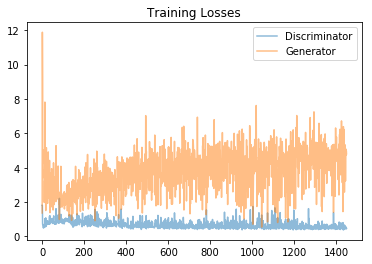

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

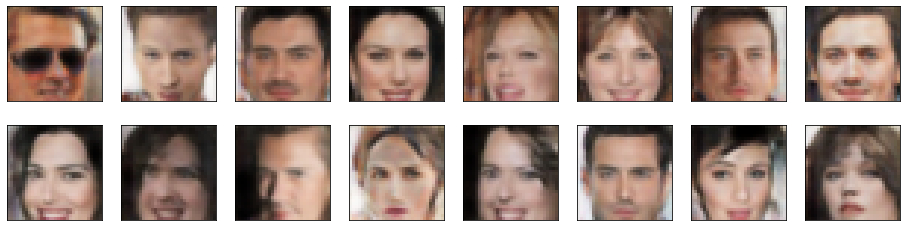

In [27]:
# for i in range(0,49,10):
#     _ = view_samples(i, samples)
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** Following are my observations for the generated samples:
1. First I created model with 3 layers of transpose convolution in generator with conv_dim as 64 and trained it for 25,50 and 100 epochs. I saw a little improvement in the result from 25 to 50 epochs but I was surprised to see result got worse after 100 epochs. 
2. Then I changed the conv_dim to 128 for the same architecture, then result was improved at 100 epochs and changes were very minimal compared to 50 and 25 epochs. The model training was stagnant. Till this point, I got 9 good face generation in 16 samples. 
3. Then I decided to add 4 Residual block to the generator with total 13 transpose convolutional layer with one fully connected layer. This architecture really improved the  results and generator was kept on training as I increased the number of epochs. I ran the training for 25, 50 and 75 epochs and got best results for samples after 75 epochs.  I got 15 good face generation out of 16 samples. This means larger model have better opportunity to learn the features and hence improved the results. I limited the training to 75 epochs because beyond 78 epochs, the training was breaking with out of memory error from GPU. I have only 6gb memory in my GPU and bigger architecture needed more GPU memory to train. As I was running out of memory, I couldn't add residual layers to the Discriminator. But I think, on the same lines it would have improved the training by forcing generator to learn better.
4. Also, most of the generated faces are white and females. It generated only 6 male faces and 10 white faces out of 16 samples. That means the training data is biased. Using more diverse data will definitely improve the result. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.